In [1]:
from glob import glob
import os
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import pure_cv as vc
from haskellian import iter as I, Iter, funcs as F, IsLeft
import scoresheet_models as sm
import robust_extraction2 as re

PATHS = sorted(glob('imgs/**/*.*', recursive=True))

### 1. Identify grid corners
- Fix `s` and `t` so that next steps are easier

**Note: the model shall only include the grid of moves, not extra rows or cols**

So, exclude the left of the first number column!

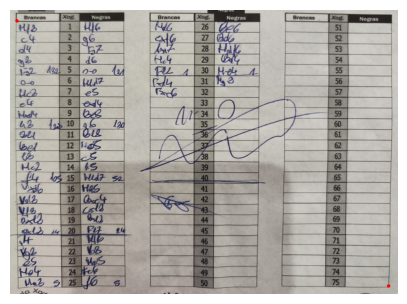

In [2]:
img = vc.imread('imgs/corrected.png')
h, w = img.shape[:2]

T = np.array([0.018, 0.042])
S = np.array([0.958, 0.93])

sheet_w = w * S[0]
sheet_h = h * S[1]

tl = T*[w, h]
br = (S+T)*[w, h]

vc.show(vc.draw.vertices(img, [tl, br], radius=10))

### 2. Find box size
- Relative box width
- Number of rows (of boxes, not grid lines)
- The image will display all points in the first block. They should match exactly only by setting `BOX_WIDTH` and `NUM_ROWS`

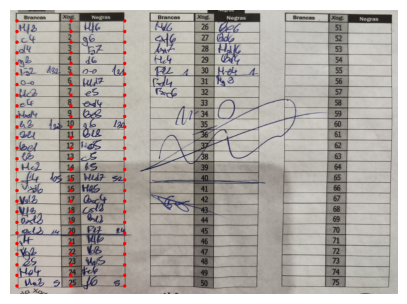

In [3]:
BOX_WIDTH = 0.145
NUM_ROWS = 25

def abs_box(box_w, num_rows):
  abs_box_w = box_w * sheet_w
  abs_box_h = sheet_h / num_rows
  return abs_box_w, abs_box_h

def block_points(top_left, box_w = BOX_WIDTH, num_rows = NUM_ROWS):
  abs_box_w, abs_box_h = abs_box(box_w, num_rows)
  first_col_lefts = [top_left + [0, abs_box_h*i] for i in range(NUM_ROWS+1)]
  first_col_rights = [top_left + [abs_box_w, abs_box_h*i] for i in range(NUM_ROWS+1)]
  second_col_rights = [top_left + [2*abs_box_w, abs_box_h*i] for i in range(NUM_ROWS+1)]
  return first_col_lefts + first_col_rights + second_col_rights

first_block_points = block_points(tl)
vc.show(vc.draw.vertices(img, first_block_points))

### 3. Find inter-block space (if applicable)
The image shows the left points of the second block numbers. They should match exactly

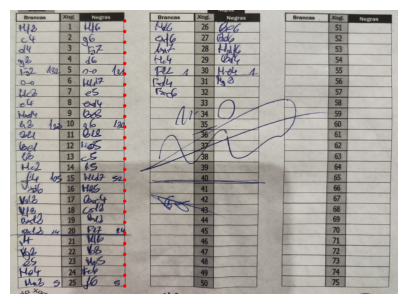

In [4]:
SPACE_W: float | None = None

abs_box_w, abs_box_h = abs_box(BOX_WIDTH, NUM_ROWS)

def abs_space(space_w = SPACE_W):
  return (space_w or 0) * sheet_w
abs_space_w = abs_space()
second_block_tl = tl + [2*abs_box_w + abs_space_w, 0]
num_points = [second_block_tl + [0, abs_box_h*i] for i in range(NUM_ROWS+1)]
vc.show(vc.draw.vertices(img, num_points))

### 4. Find number box width

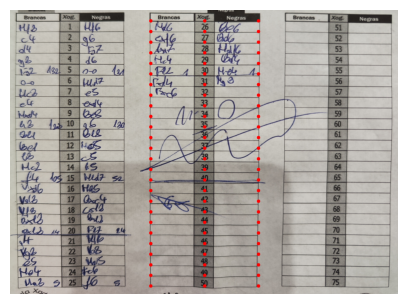

In [5]:
NUM_W: float = 0.07
abs_num_w = NUM_W * sheet_w

second_block_points = block_points(second_block_tl + [abs_num_w, 0])
vc.show(vc.draw.vertices(img, second_block_points))

### 5. Number of blocks and final adjustments

In [6]:
print('Current parameters:')
print(f'  - Box Width: {BOX_WIDTH}')
print(f'  - Space Width: {SPACE_W}')
print(f'  - Number Width: {NUM_W}')

Current parameters:
  - Box Width: 0.145
  - Space Width: None
  - Number Width: 0.07


NUM BLOCKS: 3


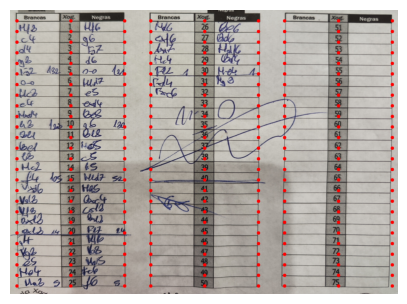

In [7]:
NUM_BLOCKS = 3
FINAL_BOX_WIDTH = BOX_WIDTH
FINAL_SPACE_W = SPACE_W
FINAL_NUM_W = NUM_W

abs_box_w, abs_box_h = abs_box(FINAL_BOX_WIDTH, NUM_ROWS)
abs_space_w = abs_space(FINAL_SPACE_W)

block_tls = [tl + [i*(2*abs_box_w + abs_space_w + abs_num_w), 0] for i in range(NUM_BLOCKS)]
all_points = I.flatten(block_points(block_tl, FINAL_BOX_WIDTH, NUM_ROWS) for block_tl in block_tls).sync()

print('NUM BLOCKS:', NUM_BLOCKS)
vc.show(vc.draw.vertices(img, all_points))

### 6. Result

Model: boxWidth=0.145 rows=25 columns=[None, 0.07, None, 0.07, None]


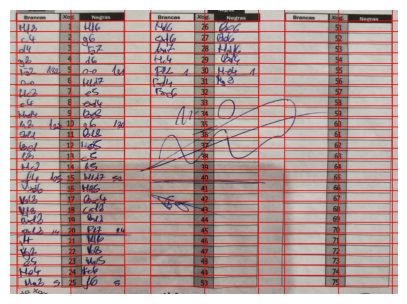

In [8]:
columns = [None]
for i in range(NUM_BLOCKS-1):
  if SPACE_W is not None:
    columns.append(SPACE_W)
  columns.extend([NUM_W, None])

model = sm.Model(boxWidth=BOX_WIDTH, rows=NUM_ROWS, columns=columns)
print('Model:', model)
vc.show(sm.draw(img, model, s=S, t=T))

### 7. Visualize Extracted Boxes

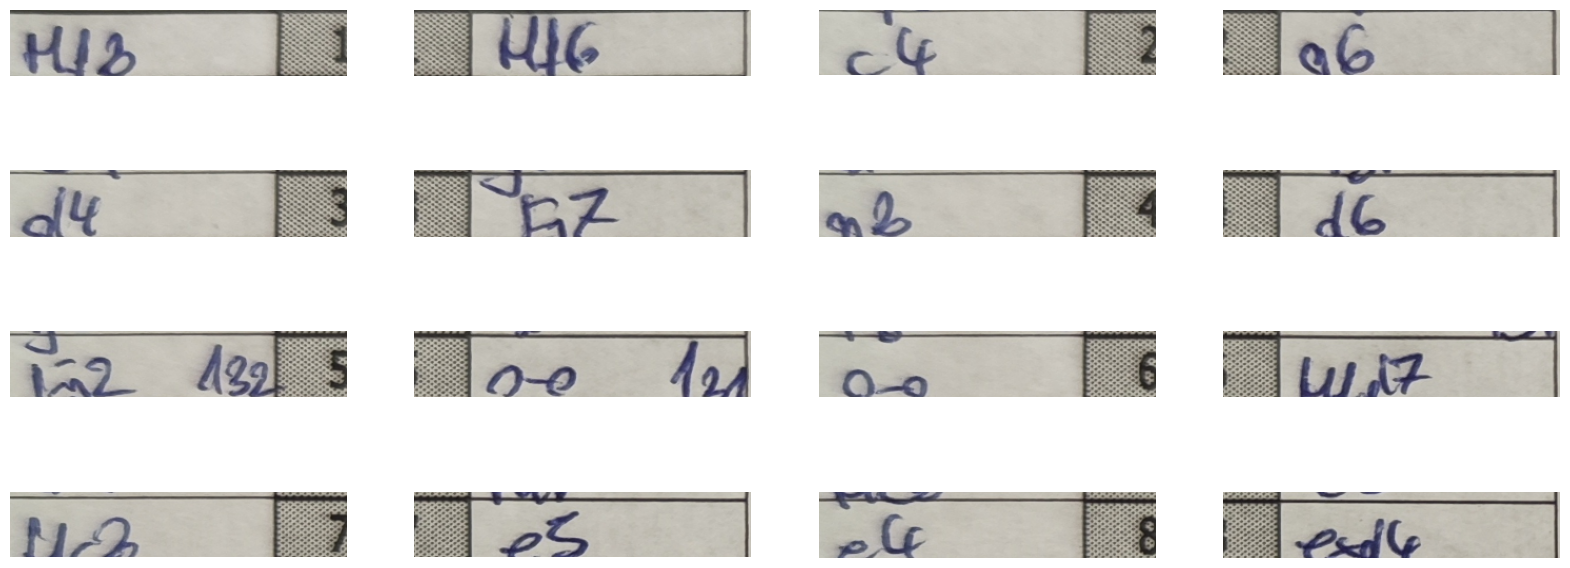

In [9]:
boxes = sm.extract_boxes(img, model, size=S, tl=T, pads=sm.Pads(l=0, r=0, t=0, b=0))
vc.show(*boxes[:16], ncols=4, height=2)

### 8. Extend model for Robust Extraction
- Visualize commonly detected extra rows and cols, and add them above in pre/post offsets
- Choose between the cells below, to see everything or just the final result

In [10]:
model = re.ExtendedModel(
  boxWidth=BOX_WIDTH, rows=NUM_ROWS, columns=columns,
  pre_row_offsets=[1/25],
  post_row_offsets=[],
  pre_col_offsets=[],
  post_col_offsets=[]
)
print(model)

boxWidth=0.145 rows=25 columns=[None, 0.07, None, 0.07, None] pre_row_offsets=[0.04] post_row_offsets=[] pre_col_offsets=[] post_col_offsets=[]


In [11]:
# JUST THE RESULT
for i, path in Iter(PATHS).enumerate().take(0):
  print(i, path)
  try:
    img = vc.imread(path)
    # if img.shape[1] > img.shape[0]:
    #   print('Skipping rotated image')
    #   continue
    corr, cnts = re.extract(img, model).unsafe()
    display(vc.show(img, vc.draw.contours(corr, cnts)))
  except (Exception, IsLeft) as e:
    print('Oops:', e)
    display(vc.show(img))

In [12]:
# # A FEW INTERMEDIATE STEPS
# for i, path in Iter(PATHS).enumerate().skip(0):
#   print(i, path)
#   try:
#     img = vc.imread(path)
#     if img.shape[1] > img.shape[0]:
#       print('Skipping rotated image')
#       continue
#     corr = re.pipeline.autocorrect(img, model).unsafe()
#     all_lines = re.pipeline.cropped_lines(corr, pad_v=model.rmin, pad_h=model.cmin)
#     rows, cols = re.pipeline.head(corr, model)
#     drawn_rows = F.pipe(corr, *[vc.draw.lines(lines=c, color=vc.mod_color(i, 6)) for i, c in enumerate(rows)])
#     drawn_cols = F.pipe(corr, *[vc.draw.lines(lines=c, color=vc.mod_color(i, 6)) for i, c in enumerate(cols)])
#     cnts = re.pipeline.extract_contours(corr, model).unsafe()
#     fig = vc.show(
#       ('Original', img),
#       ('All lines', vc.draw.lines(corr, all_lines)),
#       ('Row clusters', drawn_rows),
#       ('Column clusters', drawn_cols),
#       ('Contours', vc.draw.contours(corr, cnts)),
#       ncols=5
#     )
#     display(fig)
#   except (Exception, IsLeft) as e:
#     print('Oops:', e)
#     display(vc.show(img))

### 9. Upload to CDN

In [13]:
modelId = input('Model ID: ')
(await sm.save_model(modelId, model, conn_str=os.environ['BLOB_CONN_STR'])).unsafe()
print('Model saved! Verifying...')
fetched_model = await sm.fetch_model(modelId)
print('Fetched model:', fetched_model)

Model saved! Verifying...
Fetched model: Right(value=ExtendedModel(boxWidth=0.145, rows=25, columns=[None, 0.07, None, 0.07, None], pre_row_offsets=[0.04], post_row_offsets=[], pre_col_offsets=[], post_col_offsets=[]), tag='right')


In [14]:
kv = sm.models_kv(os.environ['BLOB_CONN_STR'])
await kv.items().sync()

[Right(value=('andorra.json', ExtendedModel(boxWidth=0.141, rows=20, columns=[None, 0.024, 0.05, None, 0.024, 0.05, None], pre_row_offsets=[0.03, 0.05], post_row_offsets=[], pre_col_offsets=[], post_col_offsets=[])), tag='right'),
 Right(value=('benasque24.json', ExtendedModel(boxWidth=0.103, rows=20, columns=[None, 0.06, None, 0.06, None, 0.06, None], pre_row_offsets=[0.05], post_row_offsets=[], pre_col_offsets=[0.06], post_col_offsets=[])), tag='right'),
 Right(value=('fcde.json', ExtendedModel(boxWidth=0.147, rows=25, columns=[None, 0.024, 0.036, None, 0.024, 0.036, None], pre_row_offsets=[0.04], post_row_offsets=[0.07200000000000001, 0.032], pre_col_offsets=[], post_col_offsets=[])), tag='right'),
 Right(value=('llobregat23.json', ExtendedModel(boxWidth=0.23, rows=30, columns=[None, 0.07, None], pre_row_offsets=[0.02666666666666667, 0.03333333333333333], post_row_offsets=[], pre_col_offsets=[], post_col_offsets=[])), tag='right'),
 Right(value=('pontevedra.json', ExtendedModel(boxW